# DirectTSQR

1.2.3 Dimensionality reduction

Dimensionality reduction can be achieved via matrix decomposition using for instance
the SVD methods. An alternative approach is to use a so-called QR decomposition or
QR factorization, where the matrix A is decomposed into a product of an orthogonal
matrix Q and an upper triangular matrix R. In the case of very large datasets, where
the number of features is much less than the number of rows (i.e. where the number of
examples is extremely large), the matrix tent to be referred to as "tall-and-skinny", and
efficient ways to perform QR decomposition can be defined.
Implement the Direct TSQR method proposed in paper https://arxiv.org/abs/1301.1071
and test its performance on one of the real-world standard datasets made available by
scikitlearn, preferably:
• California housing dataset
(https://scikit-learn.org/stable/datasets/real_world.html#california-housing-dataset)

- key represents the identity of a row, index

- value represents the elements in that row

- map applies a function to each key-value pair which outputs a transformed key-value pair; 

- second, shuffle rearranges the data to ensure that all values with the same key are together; 

- finally, reduce applies a function to all values with the same key.

In [1]:
t1, t2 = 2 , 0
cpu1, cpu2 = 2 , 0 

In [2]:
from dask.distributed import Client
from multiprocessing.pool import ThreadPool

# use the provided master
client = Client('10.67.22.243:8786')

client

<Client: 'tcp://10.67.22.243:8786' processes=2 threads=4, memory=7.67 GiB>

In [3]:
import sklearn
import dask
from sklearn import datasets
import pandas as pd
import dask.bag as db
import dask.array as da
import dask.dataframe as dd
from sklearn import datasets
import numpy as np
import numpy.linalg as la
from dask import delayed
from dask.distributed import wait
from IPython.display import Image
import matplotlib.pyplot as plt
from dask.diagnostics import ProgressBar
import graphviz
import time
import sys
from numpy import random

## Variables


## First Step

 - A1, A2, A3, A4 - A_n

 - Q11, Q21, Q31, Q41 - Q_n1

 - R1, R1, R1, R4 - R_n
 
## Second Step

 - R1, R1, R1, R4 - R_n

 - Q12, Q22, Q32, Q42 - Q_n2

 - R - R
 
## Third Step

 - Q11, Q21, Q31, Q41 - Q_n1

 - Q12, Q22, Q32, Q42 - Q_n2

 - Q - Q

## Direct MapReduce computation of Q and R.

In [4]:
def QR_decomposition(data, Q_or_R):
    return la.qr(data)[Q_or_R]

## DirectTSQR

In [13]:
def DTSQR(A_n, part):
    
    w  = np.shape(A_n)[1]
    #### Map A_n to Q_1 by QR decomposition
    Q_n1 = da.map_blocks(QR_decomposition, A_n, Q_or_R=0, chunks= (int(len(A_n)/part),w) )
    
    #### Map A_n to R_n by QR decomposition
    R_n = da.map_blocks(QR_decomposition, A_n, Q_or_R=1, chunks = (w,w) )   
    # Second step
    
    #### Map R_n to Q_n2 by QR decomposition
    R = QR_decomposition(R_n, Q_or_R=1)
    
    #### Map R_n to R by QR decomposition
    Q_n2 = QR_decomposition(R_n, Q_or_R=0).rechunk(w,w)
    
    #Third step
    
    #### Map Q from Q_n1 & Q_n2
    Q = da.map_blocks(np.dot,Q_n1, Q_n2)

    return Q, R

#### Data import

In [63]:
data = datasets.fetch_california_housing()
d = data['data']
# Height of the matrix
h = len(d)
# Width of the matrix
w = np.shape(d)[1]

#### Example

In [7]:
partitions = 4
## Create A and repartition it into A_n with n partitions
A_n_ex= da.from_array(d, chunks= (int(h/partitions),w)).compute()

Q_ex, R_ex, elapsed_time_ex = DTSQR(A_n_ex, partitions)

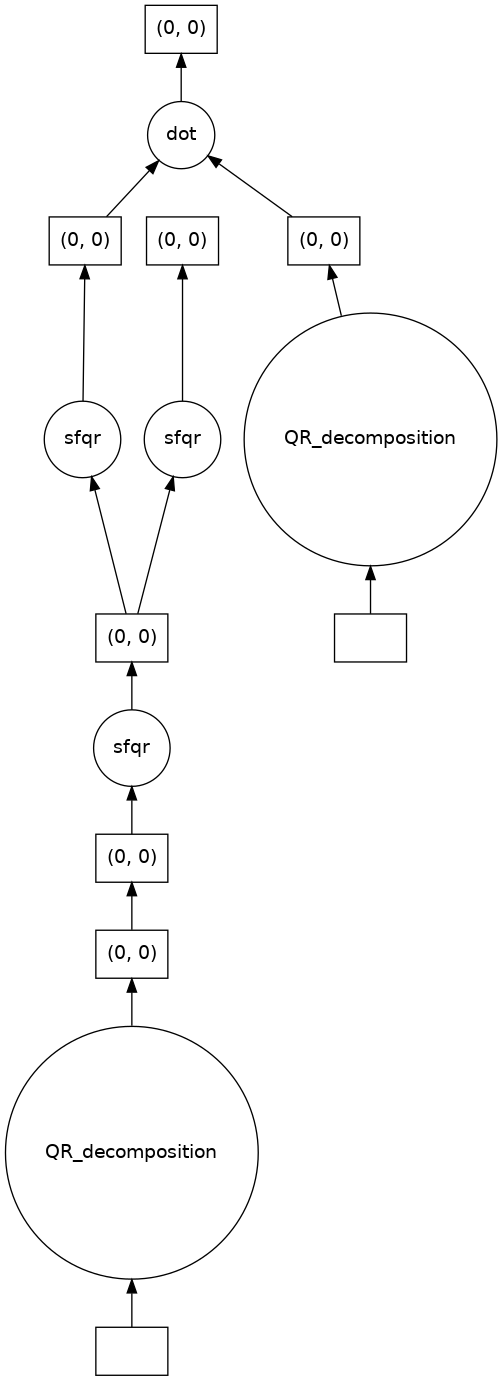

In [8]:
# graphs visualization
Q_ex.visualize()

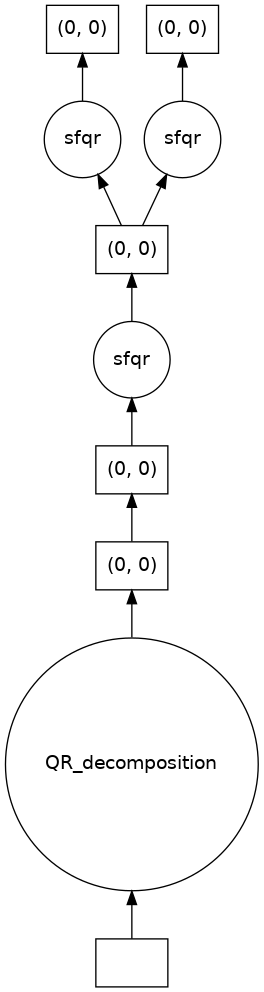

In [9]:
R_ex.visualize()

### Stability metrics

#### Accuracy

For stability, we use the metric to measure the accuracy of the decomposition:

||A − QR || / ||R||

In [10]:
def accuracy(A_n,Q,R):
    QR = da.dot(Q, R)
    acc = da.linalg.norm(A_n - QR)/da.linalg.norm(R)
    return acc

#### Orthogonality

To measure the orthogonality of the computed Q factor:

||QT Q − I ||

In [11]:
def orthogonality(Q):
    Q_T = Q.T

    QT_Q = da.dot(Q_T, Q)

    I = da.eye(np.shape(QT_Q)[0])

    ort = da.linalg.norm(QT_Q - I)
    return ort

## Part 1: Analysis of scalability due to threads change

ncpu = 1,1

In [199]:
partitions = np.array([2,4,8,12,20,40,120])
accuracies = np.array([])
orthogonalities = np.array([])
function_time = np.array([])

for p in partitions:
    A_n = da.from_array(d, chunks = (int(h/p),w))
    t_start = time.time()
    Q_temp, R_temp, _ = DTSQR(A_n, p)
    Q_temp.compute()
    R_temp.compute()
    t_fin = time.time()
    t = t_fin-t_start
    function_time = np.append(function_time,t)
    accuracies = np.append(accuracies,accuracy(A_n,Q_temp,R_temp).compute())
    orthogonalities = np.append(orthogonalities,orthogonality(Q_temp).compute())

In [200]:
# Create a DataFrame from arrays
df = pd.DataFrame({
    'partitions': partitions,
    'time': function_time,
    'accuracy': accuracies,
    'orthogonality': orthogonalities
})

# Save DataFrame to CSV file
df.to_csv(f'part1_nthreads_{t1}_{t2}.csv', index=False)

### Built-in QR decomposition

In [201]:
# NB! partition MUST be a divisor of nrow
partitions = np.array([2,4,8,12,20,40,120])
accuracies = np.array([])
orthogonalities = np.array([])
function_time = np.array([])

for p in partitions:
    A_n = da.from_array(d, chunks= (int(h/p),w))
    # take the execution time
    time_bi_init = time.time()
    Q_temp, R_temp = da.linalg.qr(A_n)
    Q_temp.compute()
    R_temp.compute()
    time_bi_fin = time.time()
    t = time_bi_fin - time_bi_init
    # save the results
    function_time = np.append(function_time,t)
    accuracies = np.append(accuracies,accuracy(A_n,Q_temp,R_temp).compute())
    orthogonalities = np.append(orthogonalities,orthogonality(Q_temp).compute())

In [202]:
# Create a DataFrame from arrays
df = pd.DataFrame({
    'partitions': partitions,
    'time': function_time,
    'accuracy': accuracies,
    'orthogonality': orthogonalities
})

# Save DataFrame to CSV file
df.to_csv(f'part1_BIQR_nthreads_{t1}_{t2}.csv', index=False)

## Part 2: Analysis of scalability due to number of cpus

best threads

In [203]:
# NB! partition MUST be a divisor of nrow
partitions = np.array([2,4,8,12,20,40,120])
accuracies = np.array([])
orthogonalities = np.array([])
function_time = np.array([])

for p in partitions:
    A_n = da.from_array(d, chunks= (int(h/p),w))
    t_start = time.time()
    Q_temp, R_temp, _ = DTSQR(A_n, p)
    Q_temp.compute()
    R_temp.compute()
    t_fin = time.time()
    t = t_fin-t_start
    function_time = np.append(function_time,t)
    accuracies = np.append(accuracies,accuracy(A_n,Q_temp,R_temp).compute())
    orthogonalities = np.append(orthogonalities,orthogonality(Q_temp).compute())

In [204]:
# Create a DataFrame from arrays
df = pd.DataFrame({
    'partitions': partitions,
    'time': function_time,
    'accuracy': accuracies,
    'orthogonality': orthogonalities
})

# Save DataFrame to CSV file
df.to_csv(f'part2_ncpus_{cpu1}_{cpu2}.csv', index=False)

### Built-in QR decomposition

In [205]:
partitions = np.array([2,4,8,12,20,40,120])
accuracies = np.array([])
orthogonalities = np.array([])
function_time = np.array([])

for p in partitions:
    A_n = da.from_array(d, chunks= (int(h/p),w))
    # take the execution time
    time_bi_init = time.time()
    Q_temp, R_temp = da.linalg.qr(A_n)
    Q_temp.compute()
    R_temp.compute()
    time_bi_fin = time.time()
    t = time_bi_fin - time_bi_init
    # save the results
    function_time = np.append(function_time,t)
    accuracies = np.append(accuracies,accuracy(A_n,Q_temp,R_temp).compute())
    orthogonalities = np.append(orthogonalities,orthogonality(Q_temp).compute())

In [206]:
# Create a DataFrame from arrays
df = pd.DataFrame({
    'partitions': partitions,
    'time': function_time,
    'accuracy': accuracies,
    'orthogonality': orthogonalities
})

# Save DataFrame to CSV file
df.to_csv(f'part2_BIQR_ncpus_{cpu1}_{cpu2}.csv', index=False)

### Benchmark

The home made QR implementation gives an average of: 0.21568129539489747 +- 0.03657970549760692
The Dask QR implementation gives an average of: 0.21287281990051268 +- 0.033859044517418106


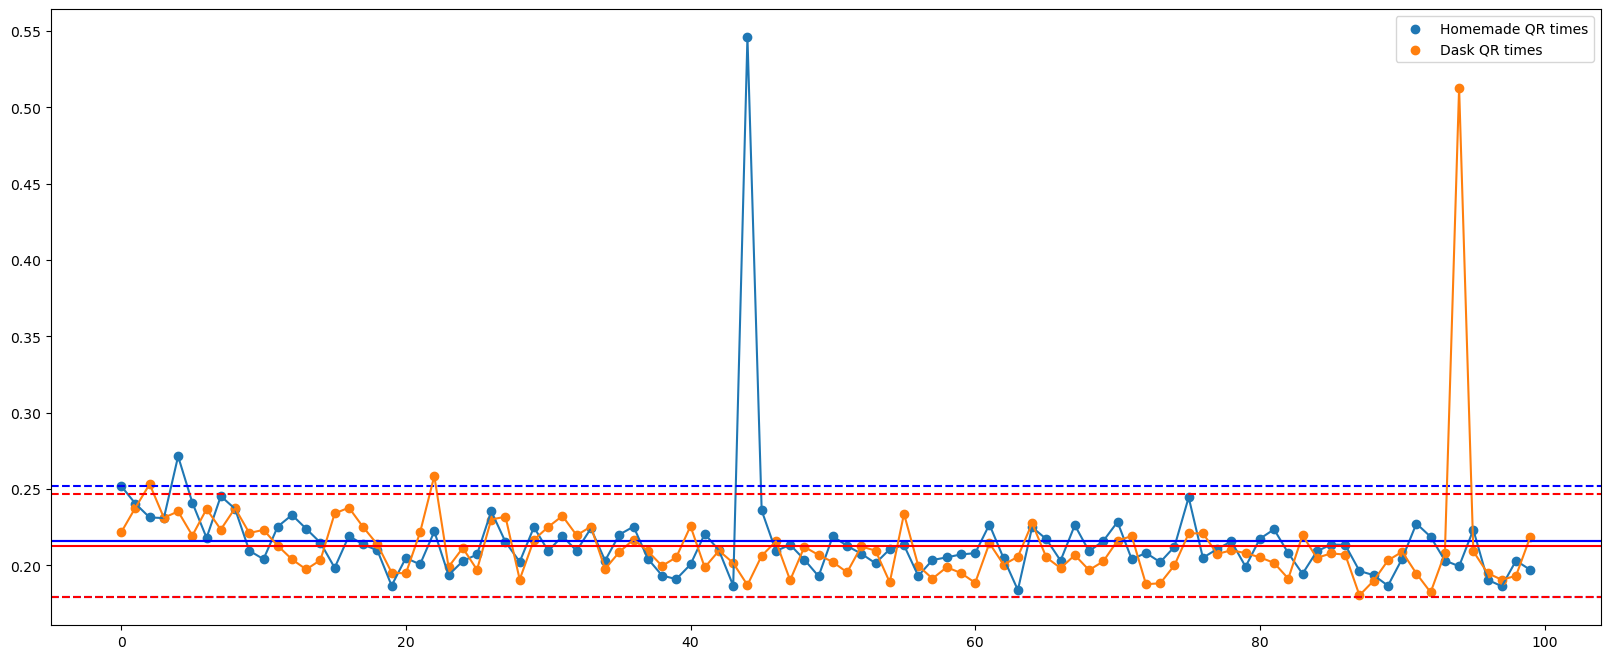

In [66]:
N = 100
tot_t_hm = np.array([])
tot_t_dask =  np.array([])
p = 4

A_n = da.from_array(d, chunks= (int(h/p),w))
A_n.compute()

for i in range(N):
    t_s = time.time()
    Q_temp, R_temp = DTSQR(A_n, partitions)
    Q_temp.compute()
    R_temp.compute()
    t_f = time.time()
    tot_t_hm = np.append(tot_t_hm, t_f-t_s )
    
    t_s = time.time()
    Q_temp, R_temp = DTSQR(A_n, partitions)
    Q_temp.compute()
    R_temp.compute()
    t_f = time.time()
    tot_t_dask = np.append(tot_t_dask, t_f-t_s )

fig = plt.figure(figsize=(20,8))

plt.plot(np.arange(0,N,1),tot_t_hm)
plt.scatter(np.arange(0,N,1),tot_t_hm, label = 'Homemade QR times')
plt.axhline(y=np.mean(tot_t_hm), color='blue')
plt.axhline(y=np.mean(tot_t_hm)+np.std(tot_t_hm), color='blue', linestyle='--')
plt.axhline(y=np.mean(tot_t_hm), color='blue')
plt.axhline(y=np.mean(tot_t_hm)-np.std(tot_t_hm), color='blue', linestyle='--')

plt.plot(np.arange(0,N,1),tot_t_dask)
plt.scatter(np.arange(0,N,1),tot_t_dask, label = 'Dask QR times')
plt.axhline(y=np.mean(tot_t_dask)+np.std(tot_t_dask), color='red', linestyle='--')
plt.axhline(y=np.mean(tot_t_dask), color='red')
plt.axhline(y=np.mean(tot_t_dask)-np.std(tot_t_dask), color='red', linestyle='--')
plt.legend()

print('The home made QR implementation gives an average of:',np.mean(tot_t_hm), '+-',np.std(tot_t_hm))
print('The Dask QR implementation gives an average of:',np.mean(tot_t_dask),'+-',np.std(tot_t_dask))



## Part 3: analysis of scalability due to data size

In [67]:
# data dimensions
h_tot = 1000000
w = 8
# generate data
d = random.random((h_tot,w))

In [208]:
partitions = np.array([10, 20, 50, 100])
sizes = [0.25, 0.5, 0.75, 1]
accuracies = np.array([])
orthogonalities = np.array([])
function_time = np.array([])

for p in partitions:
    for s in sizes:
        h = h_tot*s
        A_n = da.from_array(d[0:int(h),], chunks= (int(h/p),w))
        t_start = time.time()
        Q_temp, R_temp, _ = DTSQR(A_n, p)
        Q_temp.compute()
        R_temp.compute()
        t_fin = time.time()
        t = t_fin-t_start
        function_time = np.append(function_time,t)
        accuracies = np.append(accuracies,accuracy(A_n,Q_temp,R_temp).compute())
        orthogonalities = np.append(orthogonalities,orthogonality(Q_temp).compute())

In [209]:
# save data        
# Create a DataFrame from arrays
df = pd.DataFrame({
    'partitions': np.repeat(partitions, len(sizes)),
    'size' : sizes*len(partitions),
    'time': function_time,
    'accuracy': accuracies,
    'orthogonality': orthogonalities
    })
# Save DataFrame to CSV file
df.to_csv(f'part3_ncpu_{cpu1}_{cpu2}_nthreads_{t1}_{t2}.csv', index=False)

### Built-in QR decomposition

In [210]:
partitions = np.array([10, 20, 50, 100])
sizes = [0.25,0.5, 0.75, 1]
accuracies = np.array([])
orthogonalities = np.array([])
function_time = np.array([])

for p in partitions:
    for s in sizes:
        h = h_tot*s
        A_n = da.from_array(d[0:int(h),], chunks= (int(h/p),w))
        time_bi_init = time.time()
        Q_temp, R_temp = da.linalg.qr(A_n)
        Q_temp.compute()
        R_temp.compute() 
        time_bi_fin = time.time()
        t = time_bi_fin - time_bi_init
        function_time = np.append(function_time,t)
        accuracies = np.append(accuracies,accuracy(A_n,Q_temp,R_temp).compute())
        orthogonalities = np.append(orthogonalities,orthogonality(Q_temp).compute())

In [211]:
# save data        
# Create a DataFrame from arrays
df = pd.DataFrame({
    'partitions': np.repeat(partitions, len(sizes)),
    'size' : sizes*len(partitions),
    'time': function_time,
    'accuracy': accuracies,
    'orthogonality': orthogonalities
    })
# Save DataFrame to CSV file
df.to_csv(f'part3_BIQR_ncpu_{cpu1}_{cpu2}_nthreads_{t1}_{t2}.csv', index=False)

### Benchmark

The home made QR implementation gives an average of: 1.9928126192092896 +- 0.12159157641310323
The Dask QR implementation gives an average of: 1.997782950401306 +- 0.1522236373991926


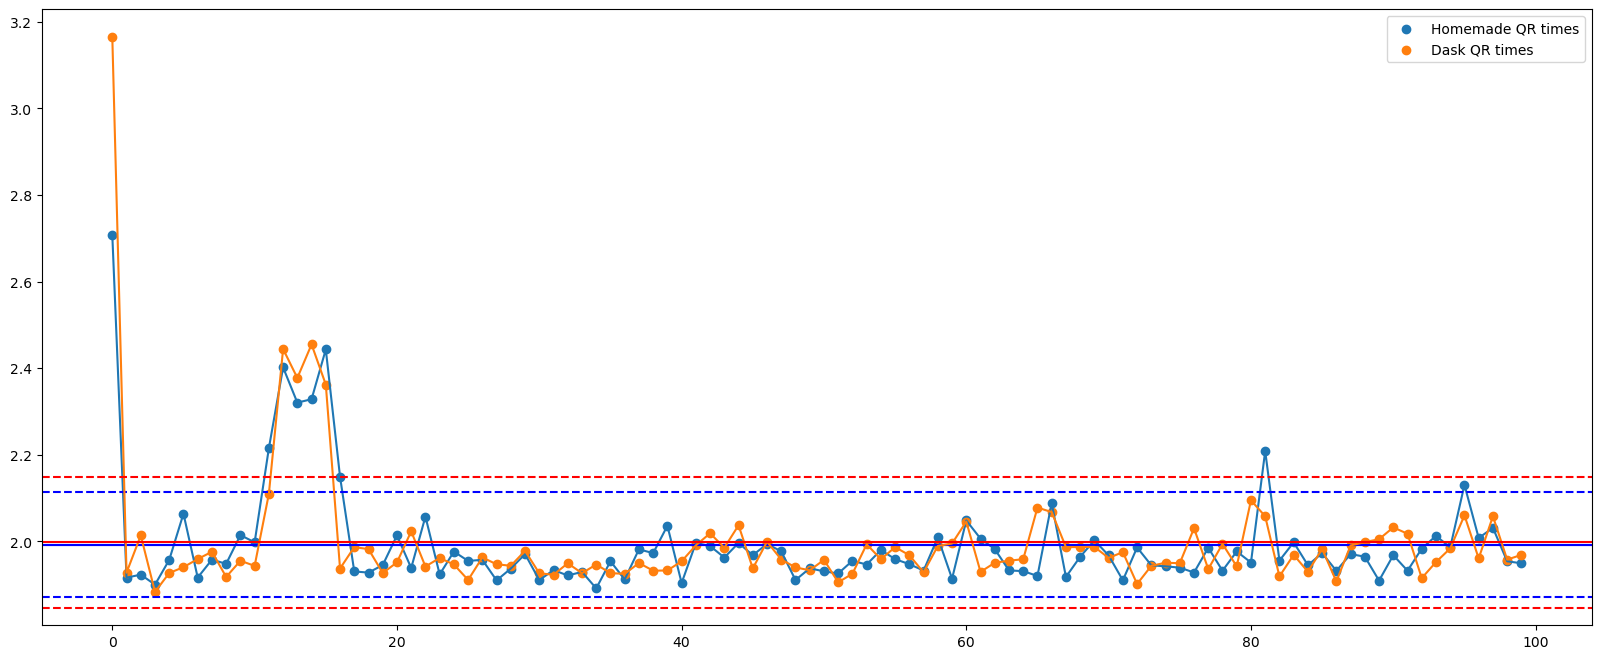

In [68]:
N = 100
tot_t_hm = np.array([])
tot_t_dask =  np.array([])
p = 4

A_n = da.from_array(d, chunks= (int(h/p),w)).compute()

for i in range(N):
    t_s = time.time()
    Q_temp, R_temp = DTSQR(A_n, partitions)
    Q_temp.compute()
    R_temp.compute()
    t_f = time.time()
    tot_t_hm = np.append(tot_t_hm, t_f-t_s )
    
    t_s = time.time()
    Q_temp, R_temp = DTSQR(A_n, partitions)
    Q_temp.compute()
    R_temp.compute()
    t_f = time.time()
    tot_t_dask = np.append(tot_t_dask, t_f-t_s )
    
fig = plt.figure(figsize=(20,8))

plt.plot(np.arange(0,N,1),tot_t_hm)
plt.scatter(np.arange(0,N,1),tot_t_hm, label = 'Homemade QR times')
plt.axhline(y=np.mean(tot_t_hm), color='blue')
plt.axhline(y=np.mean(tot_t_hm)+np.std(tot_t_hm), color='blue', linestyle='--')
plt.axhline(y=np.mean(tot_t_hm), color='blue')
plt.axhline(y=np.mean(tot_t_hm)-np.std(tot_t_hm), color='blue', linestyle='--')

plt.plot(np.arange(0,N,1),tot_t_dask)
plt.scatter(np.arange(0,N,1),tot_t_dask, label = 'Dask QR times')
plt.axhline(y=np.mean(tot_t_dask)+np.std(tot_t_dask), color='red', linestyle='--')
plt.axhline(y=np.mean(tot_t_dask), color='red')
plt.axhline(y=np.mean(tot_t_dask)-np.std(tot_t_dask), color='red', linestyle='--')
plt.legend()

print('The home made QR implementation gives an average of:',np.mean(tot_t_hm), '+-',np.std(tot_t_hm))
print('The Dask QR implementation gives an average of:',np.mean(tot_t_dask),'+-',np.std(tot_t_dask))    

### Part 4: Numpy performace

In [212]:
data = datasets.fetch_california_housing()
d = data['data']
# Height of the matrix
h = len(d)
# Width of the matrix
w = np.shape(d)[1]

In [213]:
time_1 = time.time()
Q, R = np.linalg.qr(d)
time_2 = time.time()

tot_time = time_2 - time_1

acc = np.linalg.norm(d- np.dot(Q,R))/np.linalg.norm(R)

orth = np.linalg.norm(np.dot(Q.T,Q)-np.eye(np.shape(Q)[1]))

In [214]:
h_tot = 1000000
w = 8
# generate data
d = random.random((h_tot,w))

In [215]:
time_1 = time.time()
Q, R = np.linalg.qr(d)
time_2 = time.time()

tot_time = time_2 - time_1

acc = np.linalg.norm(d- np.dot(Q,R))/np.linalg.norm(R)

orth = np.linalg.norm(np.dot(Q.T,Q)-np.eye(np.shape(Q)[1]))

In [216]:
sizes = [0.25,0.5, 0.75, 1]
accuracies = np.array([])
orthogonalities = np.array([])
function_time = np.array([])

for s in sizes:
    h = h_tot*s
    time_bi_init = time.time()
    Q_temp, R_temp = np.linalg.qr(d)
    time_bi_fin = time.time()
    t = time_bi_fin - time_bi_init
    function_time = np.append(function_time,t)
    accuracies = np.append(accuracies, np.linalg.norm(d- np.dot(Q_temp,R_temp))/np.linalg.norm(R_temp) )
    orthogonalities = np.append(orthogonalities, np.linalg.norm(np.dot(Q_temp.T,Q_temp)-np.eye(np.shape(Q_temp)[1])) )

In [217]:
# save data        
# Create a DataFrame from arrays
df = pd.DataFrame({
    'size' : sizes,
    'time': function_time,
    'accuracy': accuracies,
    'orthogonality': orthogonalities
    })
# Save DataFrame to CSV file
df.to_csv(f'part4_numpy_comparation.csv', index=False)

In [218]:
client.close()